# BASE: Calculate Regional Timeseries for Region Group

**ABOUT:**
Timelines of temperature anomalies, their variance, and their likelihood within the masking region of different polygon groups. 

## Product 4. OISST Regional Timeseries

**Objective: Calculate full sea surface temperature histories for any group of polygons**

Use this notebook to process regional timelines for any group of polygons added to the `oisstools.py` module. This notebook is intended to phase out the notebooks for specific region groups.

In [1]:
# Load Packages
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import os
import geopandas as gpd
import regionmask
import math
import oisstools as ot

# Set the workspace - local/ docker
box_root = ot.set_workspace("local")

# variable name to mask and make timeline from
var_name = "sst"

## Select Group of Regions to Process

These region groups have been added to the oisstools.py module to ensure consistent naming conventions and path retrievals.

In [3]:
# Choose a set of regions to update (gmri_sst_focal_areas, lme, nmfs_trawl_regions)

# Option 1.
# update_regions = "gmri_sst_focal_areas"

# Option 2.
# update_regions = "lme"

# Option 3.
update_regions = "nmfs_trawl_regions"

# Option 4.
# update_regions = "nelme_regions"

print(f"Process Timeseries for: {update_regions}")

Process Timeseries for: nmfs_trawl_regions


In [5]:
# Get their names from lookup catalog
region_names = ot.get_region_names(region_group = update_regions)
#print(f"Processing Timeseries for: {update_regions}")
for region in region_names:
    print(f" - {region}")

 - georges_bank
 - gulf_of_maine
 - southern_new_england
 - mid_atlantic_bight
 - inuse_strata
 - regions_collection


## Load Polygons for Each Region

georges_bank


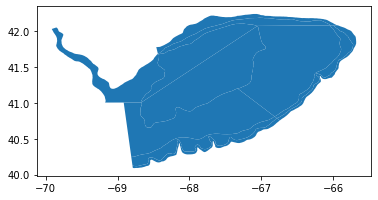

In [6]:
# Get paths to each shapefile
mask_paths = ot.get_timeseries_paths(box_root = box_root, 
                                     region_list = region_names, 
                                     region_group = update_regions, 
                                     polygons = True)

# Use paths to make list of loaded polygons
mask_list = []
for mask_path_i in mask_paths:
    mask_shape = gpd.read_file(mask_path_i)
    mask_list.append(mask_shape)
    #print(f"Loading Mask Area :  {mask_path_i}")

print(region_names[0])    
mask_list[0].plot()

## Step 2: Load OISST Collection

Timelines for these area haven't been calculates yet so it should be possible to do the full thing all at once. Steps are to load the observed data, get what the mean sst is for every day as a timeseries, as well as what the climatology is for that day of the year.

In [7]:
# Years to Include
start_yr = 1981
end_yr = 2020

# Load OISSt using ot.load_box_oisst()
oisst_grid = ot.load_box_oisst(box_root, 
                               start_yr, 
                               end_yr, 
                               anomalies = False, 
                               do_parallel = True)
# oisst_grid.sst.isel(time = 0).plot()

# Add MOD
oisst_grid = ot.add_mod(oisst_grid, time_dim = "time")

## Step 3: Load OISST Climatology

From the global extent climatology we will want to get regional means for the areas of interest.

In [8]:
# Load the OISST Climatology
# oisst_clim = xr.open_dataset(f"{box_root}RES_Data/OISST/oisst_mainstays/daily_climatologies/daily_clims_1982to2011.nc")
oisst_clim = ot.load_oisst_climatology(box_root, reference_period = "1982-2011")
oisst_clim

<xarray.Dataset>
Dimensions:               (lat: 720, lon: 1440, modified_ordinal_day: 366)
Coordinates:
  * lat                   (lat) float32 -89.875 -89.625 ... 89.625 89.875
  * lon                   (lon) float32 0.125 0.375 0.625 ... 359.625 359.875
  * modified_ordinal_day  (modified_ordinal_day) int64 1 2 3 4 ... 364 365 366
Data variables:
    sst                   (modified_ordinal_day, lat, lon) float32 ...
Attributes:
    title:          30-Year sea surface temperature climatology from NOAA OIS...
    institution:    Gulf of Maine Research Institute
    source:         NOAA/NCDC  ftp://eclipse.ncdc.noaa.gov/pub/OI-daily-v2/
    comment:        Climatologies represent mean SST for the years 1982-2011
    history:        Climatologies calculated 3/2/2020
    references:     https://www.esrl.noaa.gov/psd/data/gridded/data.noaa.oiss...
    dataset_title:  GMRI 30-Year Climatology - OISST

## Step 4: Create Masked Timeseries

So the steps to create a masked timeseries are straightforward. Once everything is prepped you simply create a mask with the geometry of the polygon of interest. You then extract the cells that fall within it, and calculatet the mean temperature and standard deviation for the area for each time step. These steps are repeated for the raw observations as well as the climate means in order to get anomalies from the 82-2011 climatology.

In [9]:
# NEW CODE - Masked Timeseries

# list to store the update period timeseries
clim_ts = [] # climatology timeseries
obs_ts = []  # temperature observations
new_ts = []  # anomaly timeseries


# Iteratre through names and shapes simultaneously
for mask_shp, mask_name in zip(mask_list, region_names):
    
    
    
    #### 1. Get masked timeseries of climatology
    masked_clim = ot.calc_ts_mask(grid_obj = oisst_clim, 
                                  shp_obj  = mask_shp, 
                                  shp_name = mask_name,
                                  var_name = "sst",
                                  climatology = True)
    
    # Add to list
    clim_ts.append(masked_clim)
    
    
    
    #### 2. Get masked Timeseries of observations
    masked_sst = ot.calc_ts_mask(grid_obj = oisst_grid, 
                                 shp_obj  = mask_shp, 
                                 shp_name = mask_name,
                                 var_name = "sst",
                                 climatology = False)
    
    # Add MOD to observation temp ts
    masked_sst = ot.add_mod_to_ts(masked_sst)
    
    # Add to list
    obs_ts.append(masked_sst)
    

    
    
    #### 3. Merge on MOD
    
    # Merge on MOD
    anom_timeline = masked_sst.merge(masked_clim, how = "left", on = "modified_ordinal_day")

    #Set index as the date, drop time
    anom_timeline.index = anom_timeline.index = anom_timeline["time"]
    anom_timeline       = anom_timeline.drop(["time"], axis = 1)

    
    
    #### 4. Calc anoms
    anom_timeline = anom_timeline.assign(anom = anom_timeline[f"{var_name}"] - anom_timeline[f"{var_name}_clim"])
    anom_timeline = anom_timeline.rename(columns = { "anom" : f"{var_name}_anom"})

    # Reset Index
    anom_timeline = anom_timeline.reset_index()

    # re-order columns for peace of mind
    anom_timeline = anom_timeline[["time", "modified_ordinal_day", f"{var_name}", f"{var_name}_clim", f"{var_name}_anom", "clim_sd"]]
    anom_timeline.head()
    
    # Add to list
    new_ts.append(anom_timeline)
    
    print(f"{mask_name} timeseries processed.")



georges_bank timeseries processed.
gulf_of_maine timeseries processed.
southern_new_england timeseries processed.
mid_atlantic_bight timeseries processed.
inuse_strata timeseries processed.
regions_collection timeseries processed.


## QA/QC Visual Inspection

In [12]:
# Inspect a table
new_ts[0].head()

,time,modified_ordinal_day,sst,sst_clim,sst_anom,clim_sd
0,1981-09-01,245,17.208355,17.619209,-0.410854,1.272818
1,1981-09-02,246,17.087124,17.554138,-0.467014,1.287565
2,1981-09-03,247,16.414795,17.534145,-1.119350,1.315193
3,1981-09-04,248,15.689451,17.474907,-1.785456,1.282639
4,1981-09-05,249,15.607397,17.431997,-1.824600,1.274386


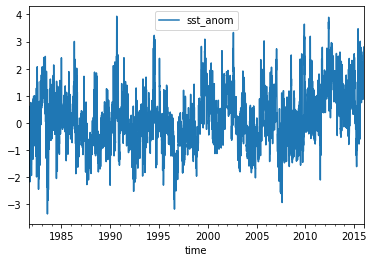

In [16]:
# Inspect via plot
new_ts[0].plot("time", "sst_anom")

## Step 5: Export

**NOTE:**
Some of the large marine ecosystem names contain a hyphen, so added an extra step to replace those.

In [17]:
# NEW Code - should be good to test

# Paths to where the timelines go
mask_ts_paths = ot.get_timeseries_paths(box_root = box_root, 
                                        region_list = region_names, 
                                        region_group = update_regions, 
                                        polygons = False)

# Use the file paths we looked up before to set the save destinations
for updated_timeline_i, update_path_i in zip(new_ts, mask_ts_paths):
    # save them
    print(f"Saving: {update_path_i}")
    updated_timeline_i.to_csv(update_path_i, index = False)

Saving: /Users/akemberling/Box/RES_Data/OISST/oisst_mainstays/regional_timeseries/nmfs_trawl_regions/OISSTv2_anom_georges_bank.csv
Saving: /Users/akemberling/Box/RES_Data/OISST/oisst_mainstays/regional_timeseries/nmfs_trawl_regions/OISSTv2_anom_gulf_of_maine.csv
Saving: /Users/akemberling/Box/RES_Data/OISST/oisst_mainstays/regional_timeseries/nmfs_trawl_regions/OISSTv2_anom_southern_new_england.csv
Saving: /Users/akemberling/Box/RES_Data/OISST/oisst_mainstays/regional_timeseries/nmfs_trawl_regions/OISSTv2_anom_mid_atlantic_bight.csv
Saving: /Users/akemberling/Box/RES_Data/OISST/oisst_mainstays/regional_timeseries/nmfs_trawl_regions/OISSTv2_anom_inuse_strata.csv
Saving: /Users/akemberling/Box/RES_Data/OISST/oisst_mainstays/regional_timeseries/nmfs_trawl_regions/OISSTv2_anom_regions_collection.csv
